# L-9-4: Inverse Classroom: It’s not working! Help!

These exercises will give you some debugging experience on problems typically found when doing machine learning in practice.

**Outline**

0. General Set-up
1. Debugging A Bad Training Set-up
2. Image Segmentation with DICE Loss
3. Fixing the Data-Processing Pipeline
4. Test Performance is Too Good!

## 0. General Set-up

Here we provide general code set-up: package requirements, train-loaders, etc.

In [1]:
## Some general imports we may need:
import numpy as np
import torch
import torch.nn as nn
#import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import struct

Make sure GPU is enabled: In Colab, at the top, 

click `Runtime` -> `Change runtime type` -> `Hardware Accelerator` -> `GPU`

In [2]:
gpu_boole = torch.cuda.is_available()

##4. Test Performance is Too Good!

* Like in L-9-1 and L-9-3, you are given a training pipeline for MNIST.
* In this case, we are doing binary classification on a subset on the digits: 0's and 8's.
* The test accuracy is close to 100% after 1 epoch. Great!
* **Deliverables:** Identify and correct possible problems with the implementation.

**Defining the model and optimizer:**
We define the model and optimizer here.

In [3]:
## Defining the model:
class Net(nn.Module):
  def __init__(self, input_size, width, num_classes):
    super(Net, self).__init__()

    ##feedfoward layers:
    self.ff1 = nn.Linear(input_size, width) #input

    self.ff2 = nn.Linear(width, width) #hidden layers
    self.ff3 = nn.Linear(width, width)

    self.ff_out = nn.Linear(width, num_classes) #logit layer     

    ##activations:
    self.relu = nn.ReLU()
                
  def forward(self, input_data):
    out = self.relu(self.ff1(input_data)) 
    out = self.relu(self.ff2(out)) 
    out = self.relu(self.ff3(out))
    out = self.ff_out(out)
    return out #returns class probabilities for each image

net = Net(input_size = 784, width = 500, num_classes = 2)
if gpu_boole:
  net = net.cuda()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()

**Data loading:**

In [4]:
#Downloading and unzipping MNIST data files:
!curl -fL -O https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!curl -fL -O https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!curl -fL -O https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!curl -fL -O https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz -f

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  38.0M      0 --:--:-- --:--:-- --:--:-- 38.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   561k      0 --:--:-- --:--:-- --:--:--  564k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  5019k      0 --:--:-- --:--:-- --:--:-- 5031k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  40812      0 --:--:-- --:--:-- --:--:-- 40918


In [5]:
##Loading files into numpy arrays:
def read_idx(filename, boole=0):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        if boole:
          return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10     
        else:
          return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

xtrain = read_idx('train-images-idx3-ubyte', 1)
xtest = read_idx('t10k-images-idx3-ubyte', 1)
ytrain = read_idx('train-labels-idx1-ubyte')
ytest = read_idx('t10k-labels-idx1-ubyte')

## Splitting into 0's and 8's:
xdata = np.concatenate([xtrain,xtest],axis=0)
ydata = np.concatenate([ytrain,ytest],axis=0)

inds_0s = ydata == 0
inds_8s = ydata == 8
ydata[inds_0s] = 1
ydata[inds_8s] = 0
xdata = np.concatenate([xdata[inds_0s],xdata[inds_8s]],axis=0)
ydata = np.concatenate([ydata[inds_0s],ydata[inds_8s]],axis=0)

N = int(round(xdata.shape[0]*0.9)) #90-10 train-test split
xtrain = xdata[:N]
xtest = xdata[N:]
ytrain = ydata[:N]
ytest = ydata[N:]

xtrain = torch.Tensor(xtrain) / 255.0
ytrain = torch.Tensor(ytrain).long()
xtest = torch.Tensor(xtest) / 255.0
ytest = torch.Tensor(ytest).long()

## data_loaders:
train = torch.utils.data.TensorDataset(xtrain, ytrain)
test = torch.utils.data.TensorDataset(xtest, ytest)

train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

/tmp/ipykernel_1241911/1685162385.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10
/tmp/ipykernel_1241911/1685162385.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


**Defining training and test loss and accuracy functions:** These functions will be useful in our training loop to view are training and test loss/accuracy at each epoch.

In [6]:
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)
        
    if verbose:
        print('Train accuracy: %f %%' % (100 * correct / total))
        print('Train loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)

    if verbose:
        print('Test accuracy: %f %%' % (100 * correct / total))
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total

**Traning loop:** here, we give the training loop. A number of epochs is set. Loss is recorded and plotted at the end.

**IMPORTANT NOTE:** For re-running this code cell, if you encounter nan loss, you will need to reinstantiate your model and optimizer by re-running the "Defining the model and optimizer:" code cell above.

Starting Training
Epoch 1 :
Train accuracy: 44.127884 %
Train loss: 0.016616
Test accuracy: 100.000000 %
Test loss: 0.000056
Elapsed time for epoch: 2.141057014465332 s
ETA of completion: 0.1427371342976888 minutes

Epoch 2 :
Train accuracy: 65.746658 %
Train loss: 0.005646
Test accuracy: 100.000000 %
Test loss: 0.000044
Elapsed time for epoch: 1.8251781463623047 s
ETA of completion: 0.09125890731811523 minutes

Epoch 3 :
Train accuracy: 89.251312 %
Train loss: 0.002335
Test accuracy: 100.000000 %
Test loss: 0.000035
Elapsed time for epoch: 1.8245055675506592 s
ETA of completion: 0.06081685225168864 minutes

Epoch 4 :
Train accuracy: 93.395386 %
Train loss: 0.001509
Test accuracy: 99.927170 %
Test loss: 0.000032
Elapsed time for epoch: 1.899655818939209 s
ETA of completion: 0.031660930315653486 minutes

Epoch 5 :
Train accuracy: 94.844193 %
Train loss: 0.001191
Test accuracy: 99.854332 %
Test loss: 0.000031
Elapsed time for epoch: 1.7192325592041016 s
ETA of completion: 0.0 minutes



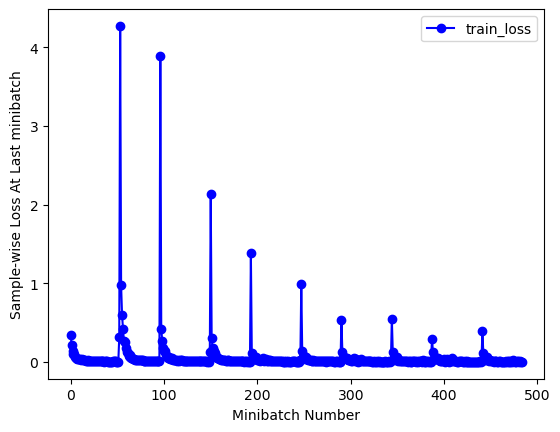

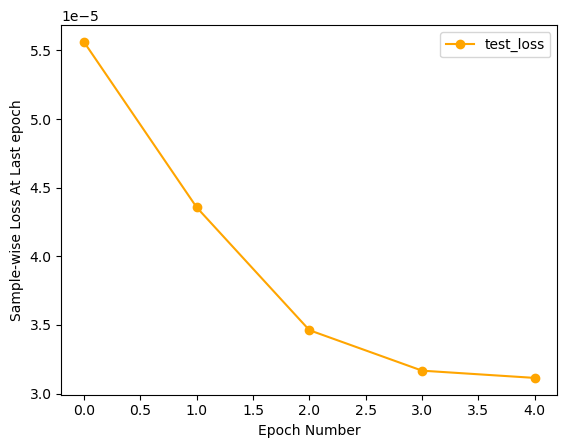

In [7]:
#re-initializing network weights:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)

weights_init(net)

#number of epochs to train for:
epochs = 5

#defining batch train loss recording arrays for later visualization/plotting:
loss_batch_store = []
test_loss_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
  time1 = time.time() #timekeeping

  for i, (x,y) in enumerate(train_loader):

    x = x.view(-1,28*28)

    if gpu_boole:
      x = x.cuda()
      y = y.cuda()

    #loss calculation and gradient update:

    if i > 0 or epoch > 0:
      optimizer.zero_grad()
    outputs = net.forward(x)
    loss = loss_metric(outputs,y)
    loss.backward()

    if i > 0 or epoch > 0:
      loss_batch_store.append(loss.cpu().data.numpy().item())
                  
    ##performing update:
    optimizer.step()

  print("Epoch",epoch+1,':')
  train_perc, train_loss = train_eval()
  test_perc, test_loss = test_eval()
  test_loss_store.append(test_loss)

  time2 = time.time() #timekeeping
  print('Elapsed time for epoch:',time2 - time1,'s')
  print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
  print()

## Plotting batch-wise train loss curve:
plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Minibatch Number')
plt.ylabel('Sample-wise Loss At Last minibatch')
plt.legend()
plt.show()

## Plotting epoch-wise test loss curve:
plt.plot(test_loss_store, '-o', label = 'test_loss', color = 'orange')
plt.xlabel('Epoch Number')
plt.ylabel('Sample-wise Loss At Last epoch')
plt.legend()
plt.show()



**Describe your modifications.**
* What modifications, if any, did you make to the code?
* Make a case for why you did or did not make any changes, and how the end results differed.